This tutorial is based on the following website: https://www.learnopencv.com/deep-learning-based-object-detection-and-instance-segmentation-using-mask-r-cnn-in-opencv-python-c/

Other references:
* https://www.pyimagesearch.com/2018/11/26/instance-segmentation-with-opencv/
* https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/


---
### Mount to Google Drive
Mount to your Google Drive to access the images and model files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_location = "/content/drive/My Drive/Crafting/ADLCV/dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## Import libraries

In [2]:
import cv2 as cv
import argparse
import numpy as np
import os.path
import sys
import random
import matplotlib.pyplot as plt

# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

---
## Load the lables of the classes

In [3]:
# Load names of classes
classesFile = dataset_location + "MaskRCNN/OpenCV/object_detection_classes_coco.txt";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

---
## Load the colours

In [4]:
# Load the colors
colorsFile = dataset_location + "MaskRCNN/OpenCV/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')

# Convert text values into RGB float values
colors = []
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

---
## Load the model

In [5]:
# Give the textGraph and weight files for the model
textGraph = dataset_location + "MaskRCNN/OpenCV/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt";
modelWeights = dataset_location + "MaskRCNN/OpenCV/frozen_inference_graph.pb";

# Load the network
net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph);
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

---
## Define drawBox function
This function draws the box with label and put the mask on the image.

we draw the boxes that were filtered through the post-processing step, on the input frame with their assigned class label and confidence scores. We also overlay the colored masks along with their contours inside the boxes. In this code, we used the same color for all the objects belonging to the same class, but you could color the different instances differently too.

In [6]:
# Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    # Print a label of class.
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # Resize the mask, threshold, color and apply it on the image
    classMask = cv.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]

    color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    #colorIndex = random.randint(0, len(colors)-1)
    #color = colors[colorIndex]

    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)

    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, 3, cv.LINE_8, hierarchy, 100)

---
## Define postprocess function
This function process the results from the detection.

The network’s output masks object is a 4-dimensional object, where the first dimension represents the number of detected boxes in the frame, the second dimension represents the number of classes in the model and the third and fourth dimensions represent the mask shape(15×15) in our example.

If the confidence of a box is less than the given threshold, the bounding box is dropped and not considered for further processing.



In [7]:
# For each frame, extract the bounding box and mask for each detected object
def postprocess(frame, boxes, masks):
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]
    
    frameH = frame.shape[0]
    frameW = frame.shape[1]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]
            
            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)

---
## Perform Image Segmentation

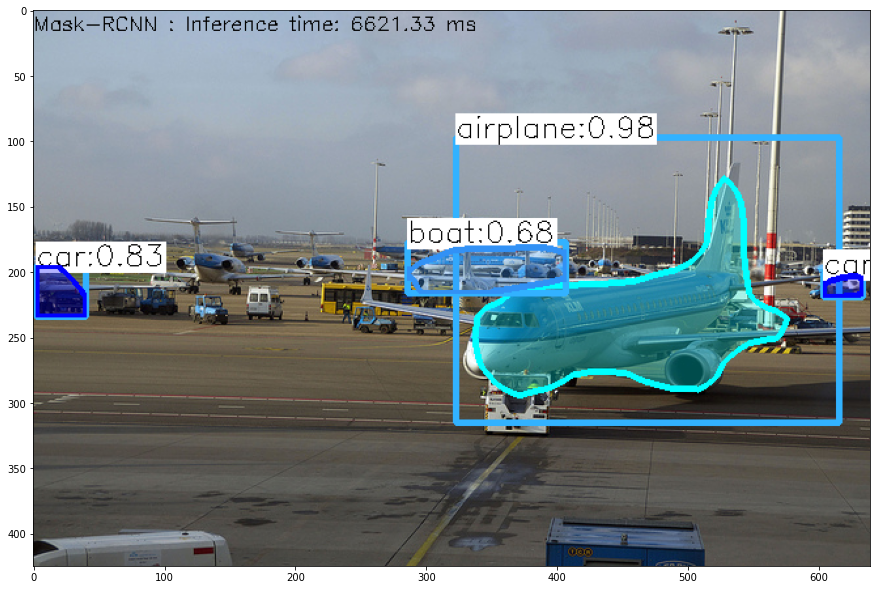

In [8]:
# Load a random image from the images folder
IMAGE_DIR = dataset_location+ "MaskRCNN/images"
file_names = next(os.walk(IMAGE_DIR))[2]
image = cv.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(image, swapRB=True, crop=False)

# Set the input to the network
net.setInput(blob)

# Run the forward pass to get output from the output layers
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

# Extract the bounding box and mask for each of the detected objects
postprocess(image, boxes, masks)

# Put efficiency information.
t, _ = net.getPerfProfile()
label = 'Mask-RCNN : Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(image, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()